### Spectrum Equation
$$
R(O, H)_{(\lambda)} = \frac{bb_{(\lambda)}}{2 K_{(\lambda)}} + \left( R_{b(\lambda)} - \frac{bb_{(\lambda)}}{2 K_{(\lambda)}}\right) e^{-2K_{(\lambda)} H}
$$

Where:
 - $R(O, H)$ is the reflectance below the water surface(i.e. glint corrected)
 - $bb_{(\lambda)}$ is the backscatter coefficient
 - $K_{(\lambda)}$ is the attenuation coefficient
 - $R_{b(\lambda)}$ is the bottom reflectance

### Glint Correction
 - Subtract the infrared intensity band from the entire spectrum

### Task: How to accurately retrieve the bottom reflectance from the spectrum?


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

from tqdm.auto import tqdm

from reflectance.spectrum import sub_surface_reflectance, AOP_model

In [3]:
validation_data = pd.read_csv('data/CORAL_validation_data.csv')
spectra_raw = pd.read_csv('data/CORAL_validation_spectra.csv')
spectra_raw.columns = spectra_raw.columns.astype(float)

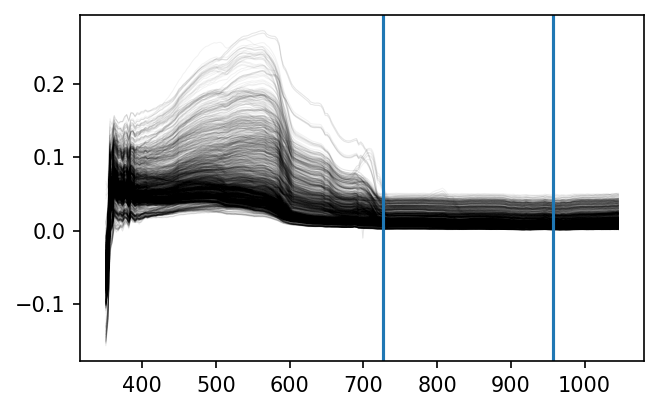

In [4]:
i = 0

plt.plot(spectra_raw.columns, spectra_raw.values.T, color=(0,0,0,0.05), lw=0.5);

plt.axvline(727)
plt.axvline(957)


In [5]:
# reflectance correction - subtract values between 727 and 957 from rest of data

ind = (spectra_raw.columns > 727) & (spectra_raw.columns < 957)
spectra_corrected = spectra_raw.subtract(spectra_raw.loc[:, ind].mean(axis=1), axis=0)


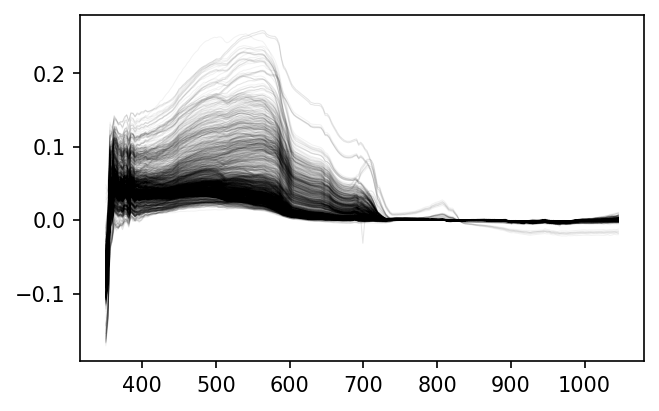

In [6]:
# plot corrected spectra
plt.plot(spectra_corrected.columns, spectra_corrected.values.T, color=(0,0,0,0.05), lw=0.5);

In [7]:
# calculate sub-surface reflectance
spectra_corrected = spectra_corrected / (0.518 + 1.562 * spectra_corrected)

In [8]:
# clip spectra to AOP valid range
ind = (spectra_corrected.columns > 450) & (spectra_corrected.columns < 690)
spectra = spectra_corrected.loc[:, ind]

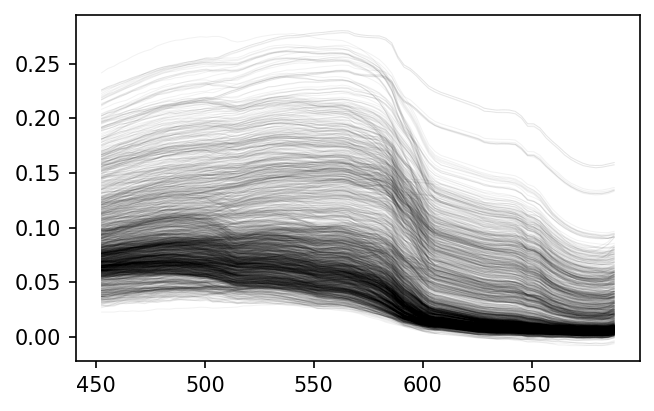

In [9]:
plt.plot(spectra.columns, spectra.values.T, color=(0,0,0,0.05), lw=0.5);

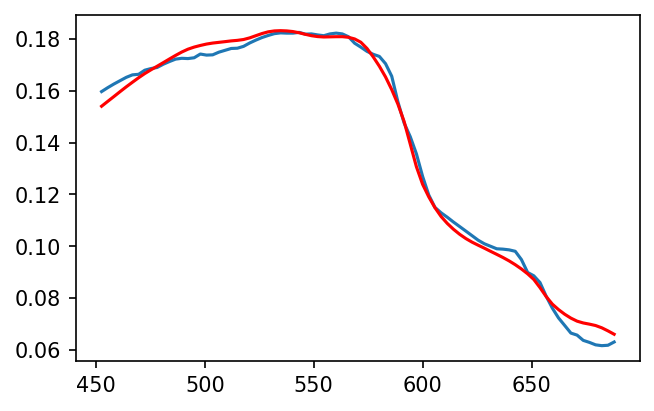

In [10]:
i = 0
plt.plot(spectra.columns, spectra.loc[i]);

AOD_sub = AOP_model.loc[spectra.columns]
AOD_args = (AOD_sub.bb_m.values, AOD_sub.bb_c.values, AOD_sub.Kd_m.values, AOD_sub.Kd_c.values)

p, cov = curve_fit(lambda x, bb, Kd, Rb, H: sub_surface_reflectance(x, bb, Kd, Rb, H, *AOD_args),
                   spectra.columns, spectra.loc[i], p0=[0.1, 0.1, 0, 0],
                   bounds=([0, 0.01688, 0, -1], [0.41123, 3.17231, np.inf, np.inf]))
plt.plot(spectra.columns, sub_surface_reflectance(spectra.columns, *p, *AOD_args), color='red')



In [26]:
fits = pd.DataFrame(index=spectra.index, columns=['bb', 'K', 'H', 'Rb'])

AOD_sub = AOP_model.loc[spectra.columns]
AOD_args = (AOD_sub.bb_m.values, AOD_sub.bb_c.values, AOD_sub.Kd_m.values, AOD_sub.Kd_c.values)

for i, row in tqdm(spectra.iterrows(), total=spectra.shape[0]):
    p, cov = curve_fit(lambda x, bb, Kd, Rb, H: sub_surface_reflectance(x, bb, Kd, Rb, H, *AOD_args),
                   spectra.columns, spectra.loc[i], p0=[0.1, 0.1, 0, 0],
                   bounds=([0, 0.01688, 0, -1], [0.41123, 3.17231, np.inf, np.inf]))
    fits.loc[i, :] = p
fits = fits.astype(float)

  0%|          | 0/1938 [00:00<?, ?it/s]

In [11]:
from sklearn.metrics import r2_score

0.7341009849168347


(0.0, 40.0)

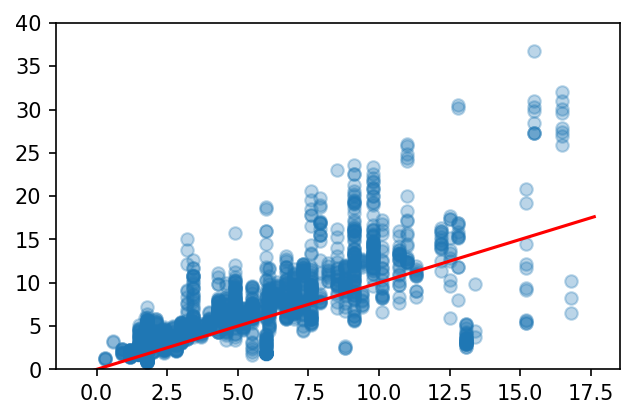

In [27]:
fig, ax = plt.subplots()
ax.scatter(validation_data.Depth, fits.H, alpha=0.3)
ax.plot(ax.get_xlim(),ax.get_xlim(), color='r')

p = np.polyfit(validation_data.Depth, fits.H, 1)
pred = np.polyval(p, validation_data.Depth)
r2 = r2_score(validation_data.Depth, pred)
print(r2)

ax.set_ylim(0,40)

## PCA-based Rb model

In [13]:
from sklearn.decomposition import PCA

In [14]:
f = 'reflectance/resources/spectral_library_clean_v3_PRISM_wavebands.csv'
df = pd.read_csv(f, skiprows=1).set_index('wavelength')
df.columns = df.columns.astype(float)
df = df.astype(float)

# clip to valid wv range
df = df.loc[:, spectra.columns]

In [128]:
pca = PCA(5)
pca.fit_transform(df)

print(pca.explained_variance_ratio_.cumsum())

def Rb_pca(p0, p1, p2):
    return p0 * pca.components_[0] + p1 * pca.components_[1] + p2 * pca.components_[2]

[0.96170481 0.98014992 0.99342982 0.99609861 0.99808346]


In [129]:
def sub_surface_reflectance_Rb(wv, bb, K, H, Rb0, Rb1, Rb2, bb_m, bb_c, Kd_m, Kd_c):
    Rb = Rb_pca(Rb0, Rb1, Rb2)
    return sub_surface_reflectance(wv, bb, K, H, Rb, bb_m, bb_c, Kd_m, Kd_c)


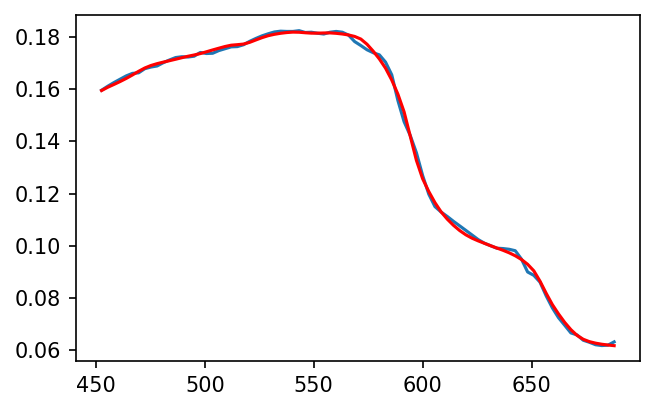

In [130]:
i = 0
plt.plot(spectra.columns, spectra.loc[i]);

AOD_sub = AOP_model.loc[spectra.columns]
AOD_args = (AOD_sub.bb_m.values, AOD_sub.bb_c.values, AOD_sub.Kd_m.values, AOD_sub.Kd_c.values)

p, cov = curve_fit(lambda x, bb, Kd, H, Rb0, Rb1, Rb2: sub_surface_reflectance_Rb(x, bb, Kd, H, Rb0, Rb1, Rb2, *AOD_args),
                   spectra.columns, spectra.loc[i], p0=[0.1, 0.1, 0, 0, 0, 0],
                   bounds=([0, 0.01688, 0, -np.inf,-np.inf,-np.inf], [0.41123, 3.17231, np.inf, np.inf, np.inf, np.inf]))
plt.plot(spectra.columns, sub_surface_reflectance_Rb(spectra.columns, *p, *AOD_args), color='red')

[]

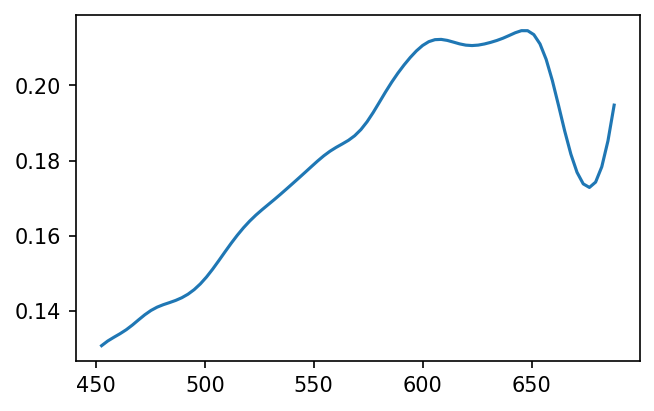

In [131]:
plt.plot(spectra.columns, Rb_pca(*p[-3:]))
plt.plot()

In [132]:
fits = pd.DataFrame(index=spectra.index, columns=['bb', 'K', 'H', 'Rb0', 'Rb1', 'Rb2'])
for i, row in tqdm(spectra.iterrows(), total=spectra.shape[0]):
    p, cov = curve_fit(lambda x, bb, Kd, H, Rb0, Rb1, Rb2: sub_surface_reflectance_Rb(x, bb, Kd, H, Rb0, Rb1, Rb2, *AOD_args),
                   spectra.columns, spectra.loc[i], p0=[0.1, 0.1, 0, 0, 0, 0],
                   bounds=([0, 0.01688, 0, 0,-np.inf,-np.inf], [0.41123, 3.17231, np.inf, np.inf, np.inf, np.inf]))
    fits.loc[i, :] = p
fits = fits.astype(float)

  0%|          | 0/1938 [00:00<?, ?it/s]

0.44676748748628703


(0.0, 40.0)

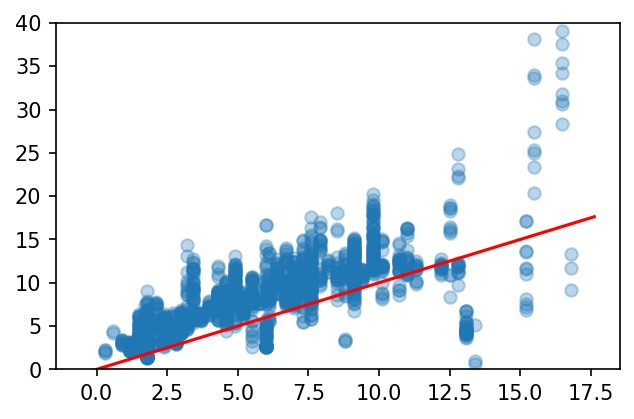

In [133]:
fig, ax = plt.subplots()
ax.scatter(validation_data.Depth, fits.H, alpha=0.3)
ax.plot(ax.get_xlim(),ax.get_xlim(), color='r')

p = np.polyfit(validation_data.Depth, fits.H, 1)
pred = np.polyval(p, validation_data.Depth)
r2 = r2_score(validation_data.Depth, pred)
print(r2)

ax.set_ylim(0,40)

In [134]:
df.divide(df.max(axis=1), axis=0)

,452.642775,455.475056,458.307394,461.139788,463.972238,466.804744,469.637306,472.469925,475.302600,478.135331,...,662.383497,665.219940,668.056439,670.892995,673.729607,676.566275,679.402999,682.239779,685.076616,687.913509
wavelength,,,,,,,,,,,,,,,,,,,,,
algae_crustose_coralline,0.363350,0.368473,0.372627,0.376945,0.382182,0.388302,0.394906,0.401319,0.406853,0.411063,...,0.727706,0.670020,0.619156,0.579217,0.552297,0.539278,0.540224,0.556016,0.588288,0.638790
algae_crustose_coralline,0.366067,0.371628,0.376690,0.381472,0.385972,0.390444,0.395256,0.400439,0.405508,0.410016,...,0.687371,0.626970,0.573762,0.532296,0.504700,0.491273,0.492001,0.508023,0.542009,0.596856
algae_crustose_coralline,0.334134,0.339320,0.342474,0.345070,0.348811,0.354589,0.362343,0.371186,0.379746,0.386814,...,0.774197,0.714940,0.662337,0.621378,0.594629,0.583036,0.587022,0.607736,0.646570,0.704787
algae_crustose_coralline,0.300231,0.304772,0.307798,0.309967,0.312439,0.316301,0.322066,0.329355,0.337136,0.344471,...,0.774378,0.718568,0.670152,0.634948,0.616045,0.614227,0.628114,0.657257,0.702217,0.763907
algae_crustose_coralline,0.306084,0.310031,0.313369,0.316933,0.321090,0.325803,0.331221,0.337079,0.343162,0.349220,...,0.740451,0.682225,0.632227,0.595799,0.575412,0.570976,0.581278,0.607155,0.650785,0.715017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
seagrass,0.549287,0.556241,0.563652,0.571801,0.580196,0.588031,0.594758,0.600327,0.604584,0.607886,...,0.670811,0.650339,0.633430,0.622227,0.618111,0.621494,0.632688,0.652435,0.681740,0.721642
seagrass,0.350862,0.355553,0.360765,0.366287,0.371778,0.376779,0.381415,0.385655,0.389096,0.391592,...,0.452276,0.431223,0.413799,0.401358,0.394907,0.395372,0.405012,0.429010,0.473994,0.545677
seagrass,0.470566,0.476414,0.482766,0.488867,0.494004,0.498131,0.502025,0.506129,0.510521,0.515237,...,0.663277,0.639333,0.619559,0.606023,0.599609,0.601240,0.612560,0.636490,0.676795,0.737053


In [20]:
# generate end-member library
cats = df.index.unique()
end_members = {}
pc1_end_members = {}

for cat in cats:
    ind = df.index == cat
    end_members[cat] = df.loc[ind].mean(axis=0)
    
    pca = PCA(1).fit(df.loc[ind])
    pc1_end_members[cat] = pca.components_[0]
    print(cat, pca.explained_variance_ratio_)
    
end_member_array = np.array([spectrum.values for spectrum in end_members.values()])

algae_crustose_coralline [0.97393545]
algae_fleshy_brown [0.98329319]
algae_fleshy_green [0.93680697]
algae_fleshy_red [0.92994224]
algae_turf [0.96438881]
coral_blue [0.92407881]
coral_brown [0.92141111]
mud [0.94956251]
octocoral [0.97396846]
sand [0.9673893]
seagrass [0.95635342]


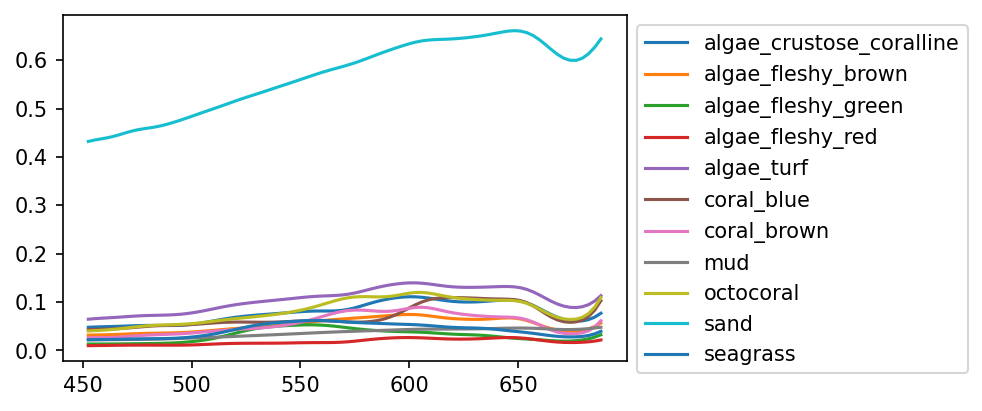

In [25]:
for cat, spectrum in end_members.items():
    line = plt.plot(spectrum.index, spectrum.values, label=cat)
    # plt.plot(spectrum.index, pc1_end_members[cat] + spectrum.min(), color=line[0].get_color(), ls='--')
plt.legend(bbox_to_anchor=(1,1))

In [137]:
from scipy.optimize import minimize
from sklearn.metrics import r2_score

In [138]:
def endmember_fit(X, y):
    return np.sum((end_member_array.T.dot(X) - y)**2)

In [139]:
endmember_coefficients = pd.DataFrame(index=fits.index, columns=np.concat([cats, ['r2']]))

for i, row in tqdm(fits.iterrows(), total=fits.shape[0]):
    Rb = Rb_pca(*row.values[-3:])
    res = minimize(endmember_fit, np.zeros(11), args=(Rb), bounds=[(0,np.inf)]*11)
    Rb_pred = end_member_array.T.dot(res.x)
    
    endmember_coefficients.loc[i] = np.concat([res.x, [r2_score(Rb, Rb_pred)]]) 


  0%|          | 0/1938 [00:00<?, ?it/s]

In [294]:
# endmember_coefficients
# for i, row in endmember_coefficients.iterrows():
#     Rb = Rb_pca(*fits.loc[i].values[-3:])
#     Rb_fit = end_member_array.T.dot(endmember_coefficients.loc[i].values[:-1])
#     endmember_coefficients.loc[i, 'r2'] = r2_score(Rb, Rb_fit)

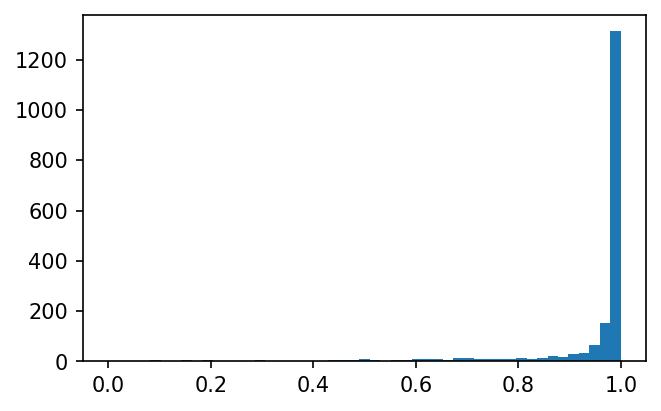

In [142]:
plt.hist(endmember_coefficients.r2, bins=np.linspace(0,1,50));

Text(0.5, 1.0, '0.684705310518094')

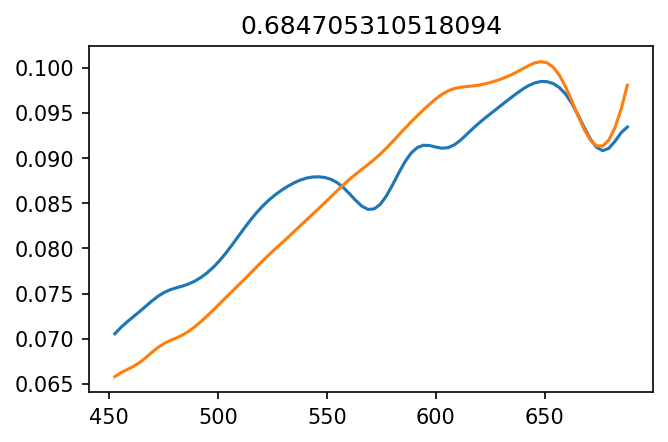

In [143]:
i = 88

Rb = Rb_pca(*fits.loc[i, ['Rb0', 'Rb1', 'Rb2']].values)

Rb_fit = end_member_array.T.dot(endmember_coefficients.loc[i].values[:-1])

plt.plot(spectra.columns, Rb)
plt.plot(spectra.columns, Rb_fit)
plt.title(endmember_coefficients.loc[i].values[-1])

In [203]:
threshold = 0.4

bad_fits = endmember_coefficients[endmember_coefficients.r2 < threshold]
good_fits = endmember_coefficients[endmember_coefficients.r2 >= threshold]

bad_fits.shape

(119, 12)

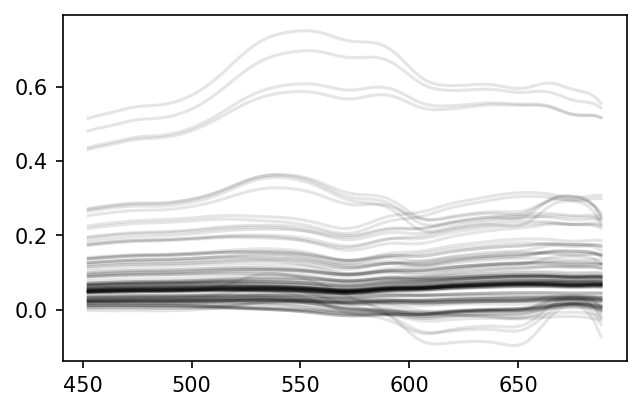

In [204]:
fig, ax = plt.subplots()

for i, row in bad_fits.iterrows():
    Rb = Rb_pca(*fits.loc[i, ['Rb0', 'Rb1', 'Rb2']].values)
    # Rb_fit = end_member_array.T.dot(row.values[:-1])
    ax.plot(spectra.columns, Rb, color='black', alpha=0.1)

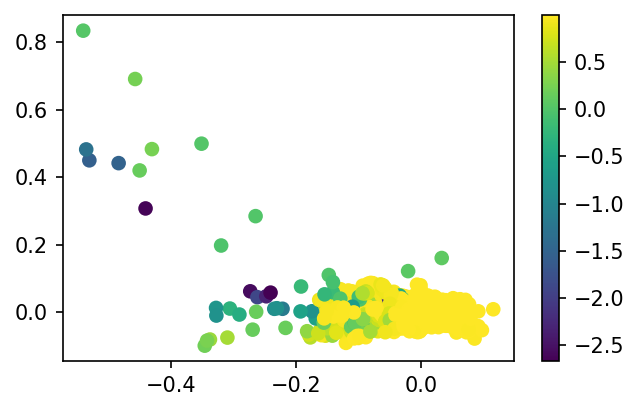

In [211]:
plt.scatter(fits.Rb1, fits.Rb2, c=endmember_coefficients.r2)
plt.colorbar()

In [201]:
validation_data.loc[ind].Station.unique()

array([609, 618, 617, 607, 608, 645, 646, 648, 647, 642, 640, 643, 641,
       650, 644, 639, 604, 603, 605, 606, 634, 635, 601, 602, 623, 622,
       632, 633, 610, 611, 630, 631, 626, 627, 628, 629, 612, 613, 616,
       615, 614, 619, 620, 625, 624])

421

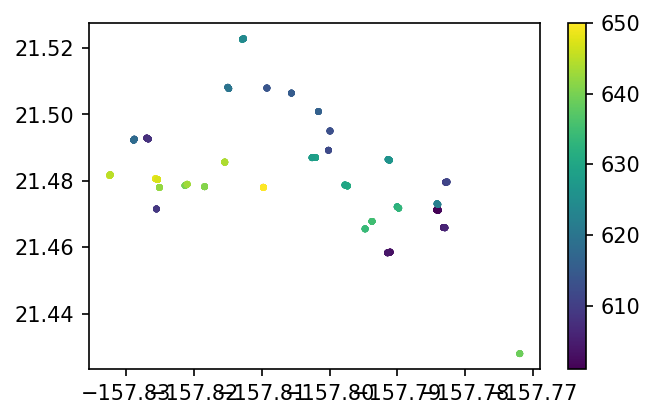

In [202]:

order = np.argsort(endmember_coefficients.r2)[::-1]

ind = validation_data.Locale == 'Kaneohe Bay'

# plt.scatter(validation_data.X[order].loc[ind], validation_data.Y[order].loc[ind], c=endmember_coefficients.r2[order].loc[ind], s=5, vmin=0, vmax=1)
plt.scatter(validation_data.X[order].loc[ind], validation_data.Y[order].loc[ind], c=validation_data.Station[order].loc[ind], s=5)
plt.colorbar()
sum(ind)

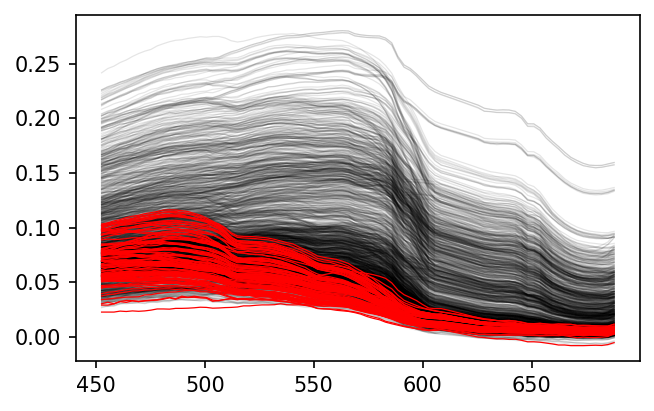

In [212]:
plt.plot(spectra.columns, spectra.loc[bad_fits.index].values.T, color='red', lw=0.6)
plt.plot(spectra.columns, spectra.loc[good_fits.index].values.T, color='k', alpha=0.1, lw=0.6, zorder=-2);

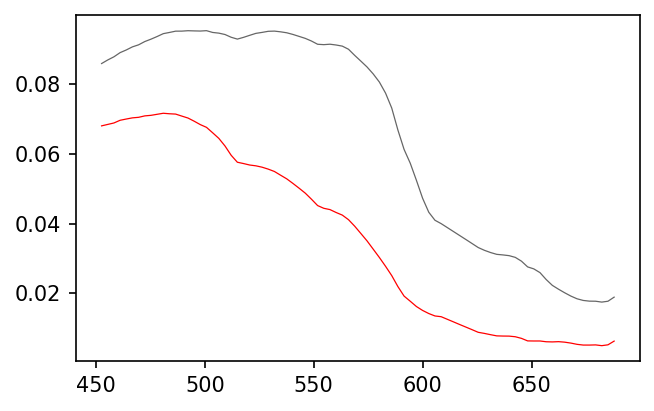

In [215]:
plt.plot(spectra.columns, spectra.loc[bad_fits.index].mean(axis=0), color='red', lw=0.6)
plt.plot(spectra.columns, spectra.loc[good_fits.index].mean(axis=0), color='k', alpha=0.6, lw=0.6, zorder=-2);

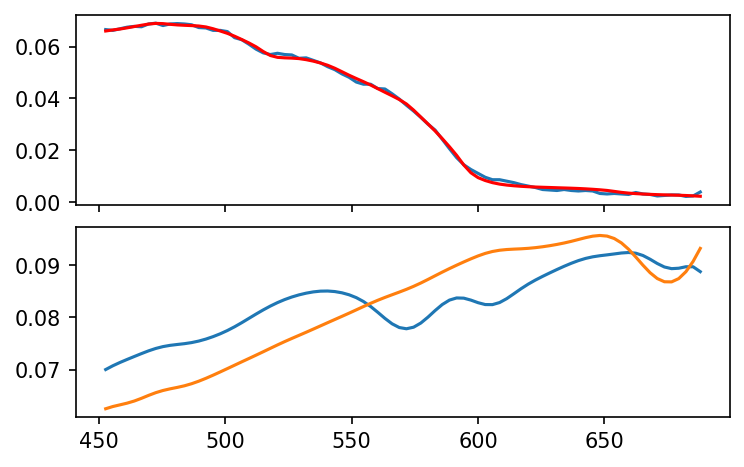

In [256]:
i = bad_fits.index[1]
# i = good_fits.index[1]
fig, axs = plt.subplots(2, 1, sharex=True, constrained_layout=True)

ax = axs[0]

ax.plot(spectra.columns, spectra.loc[i]);

AOD_sub = AOP_model.loc[spectra.columns]
AOD_args = (AOD_sub.bb_m.values, AOD_sub.bb_c.values, AOD_sub.Kd_m.values, AOD_sub.Kd_c.values)

# fit_bkg = sub_surface_reflectance(spectra.columns, *fits.loc[i].values[:-3], 0.08, *AOD_args)
fit_Rb = sub_surface_reflectance_Rb(spectra.columns, *fits.loc[i].values, *AOD_args)

# ax.plot(spectra.columns, fit_bkg, color='k')
ax.plot(spectra.columns, fit_Rb, color='red')

ax = axs[1]

Rb = Rb_pca(*fits.loc[i, ['Rb0', 'Rb1', 'Rb2']].values)
Rb_fit = end_member_array.T.dot(endmember_coefficients.loc[i].values[:-1])

ax.plot(spectra.columns, Rb)
ax.plot(spectra.columns, Rb_fit)

In [68]:
fits.loc[i]

bb      0.008530
K       0.060099
H      11.398462
Rb0     0.806380
Rb1    -0.135564
Rb2    -0.035022
Name: 90, dtype: float64

0.44676748748628703


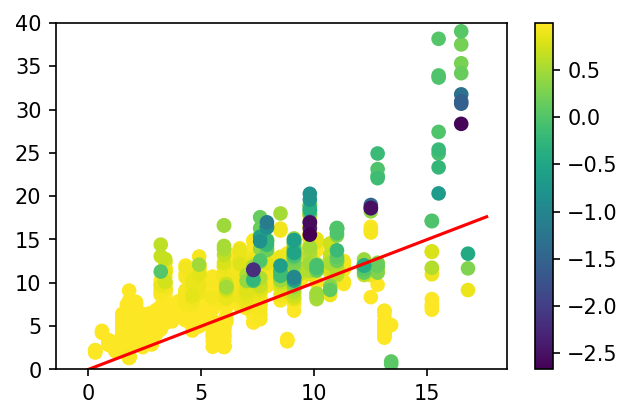

In [217]:
fig, ax = plt.subplots()

order = np.argsort(endmember_coefficients.r2)[::-1]
ma = ax.scatter(validation_data.Depth[order], fits.H[order], c=endmember_coefficients.r2[order])
ax.plot(ax.get_xlim(),ax.get_xlim(), color='r')

p = np.polyfit(validation_data.Depth, fits.H, 1)
pred = np.polyval(p, validation_data.Depth)
r2 = r2_score(validation_data.Depth, pred)
print(r2)

ax.set_ylim(0,40)

fig.colorbar(ma)

In [244]:
endmember_map = {
    'algae_crustose_coralline': ['algCCA'],
    'algae_fleshy_brown': ['algMacBrn'],
    'algae_fleshy_green': ['algMacGrn', 'algMacMix', 'algMacUnk', 'algCyano'],
    'algae_fleshy_red': ['algMacRed'],
    'algae_turf': ['algTurf'],
    'coral_blue': [],
    'coral_brown': ['crlCoral'],
    'mud': ['sedMud'],
    'octocoral': ['othOcto'],
    'sand': ['sedSand', 'crlBleach', 'sedLimest', 'sedRubble'],
    'seagrass': ['othSeagr'],
    # 'other': ['othClam', 'othInvert', 'othOther', 'othSponge', 'othUrchin']
}

validation_data_mapped = pd.DataFrame(index=validation_data.index, columns=endmember_map)

for k, v in endmember_map.items():
    validation_data_mapped.loc[:, k] = validation_data.loc[:, v].sum(axis=1) 

validation_data_mapped_norm = validation_data_mapped.divide(validation_data_mapped.sum(axis=1), axis=0)

endmember_coefficients_norm = endmember_coefficients.iloc[:, :-1]
endmember_coefficients_norm = endmember_coefficients_norm.divide(endmember_coefficients_norm.sum(axis=1), axis=0)

In [251]:
validation_data_mapped_norm['coral'] = validation_data_mapped_norm[['coral_blue', 'coral_brown']].sum(axis=1)
endmember_coefficients_norm['coral'] = endmember_coefficients_norm[['coral_blue', 'coral_brown']].sum(axis=1)

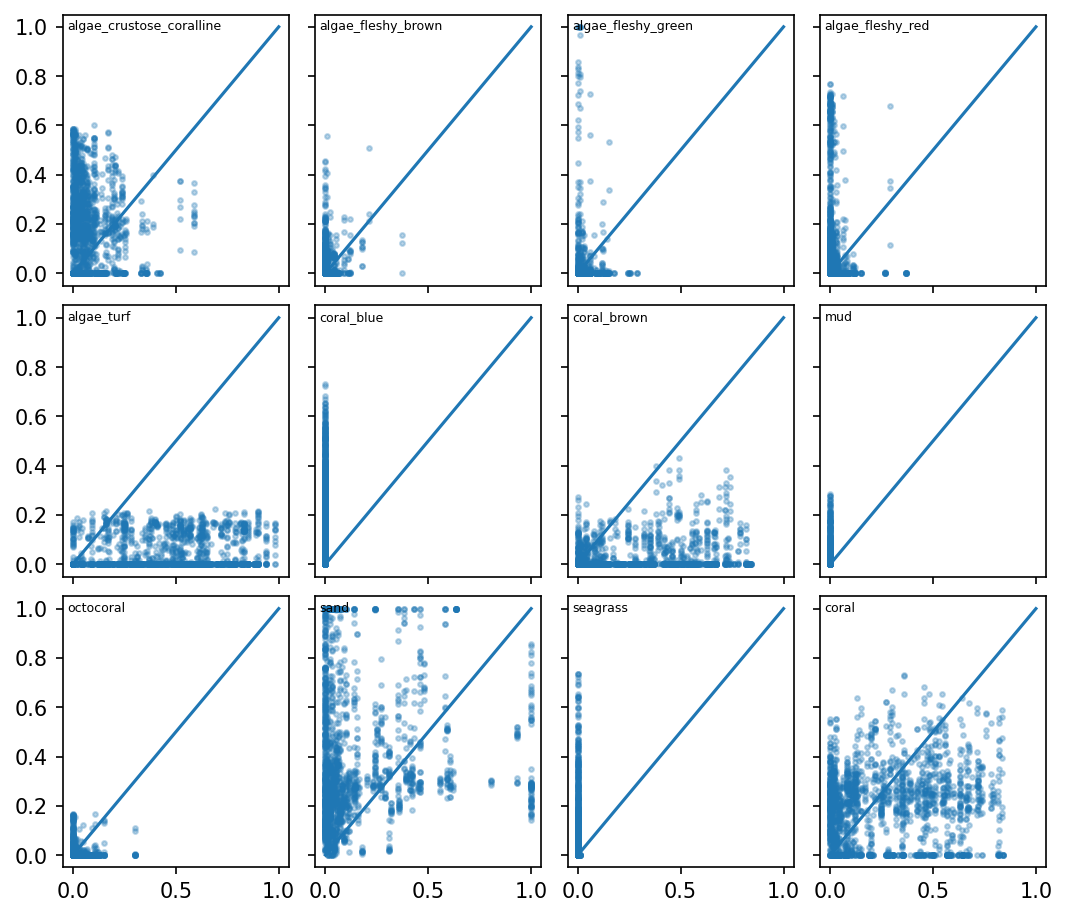

In [253]:
fig, axs = plt.subplots(3,4,figsize=[7, 6],sharex=True,sharey=True, constrained_layout=True)

for endmember, ax in zip(endmember_coefficients_norm.columns, axs.flat):
    ax.scatter(validation_data_mapped_norm[endmember], endmember_coefficients_norm[endmember], s=5, alpha=0.3)
    ax.text(0.02, 0.98, endmember, ha='left', va='top', transform=ax.transAxes, fontsize=6)
    
    ax.plot([0,1], [0,1])

([<matplotlib.axis.XTick at 0x7d79acc31850>,
 [Text(0, 0, 'algCCA'),
  Text(1, 0, 'algCyano'),
  Text(2, 0, 'algMacBrn'),
  Text(3, 0, 'algMacGrn'),
  Text(4, 0, 'algMacMix'),
  Text(5, 0, 'algMacRed'),
  Text(6, 0, 'algMacUnk'),
  Text(7, 0, 'algTurf'),
  Text(8, 0, 'crlCoral'),
  Text(9, 0, 'crlBleach'),
  Text(10, 0, 'othOcto'),
  Text(11, 0, 'othSeagr'),
  Text(12, 0, 'othClam'),
  Text(13, 0, 'othInvert'),
  Text(14, 0, 'othOther'),
  Text(15, 0, 'othSponge'),
  Text(16, 0, 'othUrchin'),
  Text(17, 0, 'sedLimest'),
  Text(18, 0, 'sedMud'),
  Text(19, 0, 'sedRubble'),
  Text(20, 0, 'sedSand')])

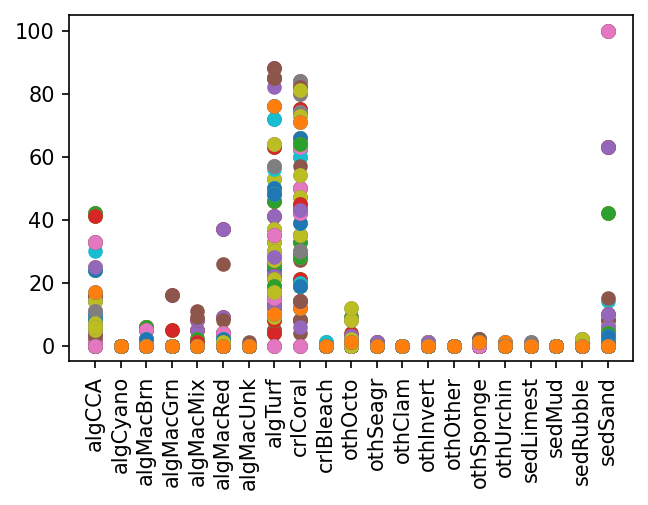

In [38]:
fig, ax = plt.subplots()

cat_columns = ['algCCA', 'algCyano',
       'algMacBrn', 'algMacGrn', 'algMacMix', 'algMacRed', 'algMacUnk',
       'algTurf', 'crlCoral', 'crlBleach', 'othOcto', 'othSeagr', 'othClam',
       'othInvert', 'othOther', 'othSponge', 'othUrchin', 'sedLimest',
       'sedMud', 'sedRubble', 'sedSand']

# for i, row in validation_data.loc[bad_fits.index].iterrows():
#     plt.scatter(range(len(cat_columns)), row[cat_columns])

# plt.xticks(range(len(cat_columns)), cat_columns, rotation=90);

In [219]:
endmember_coefficients.head()

,algae_crustose_coralline,algae_fleshy_brown,algae_fleshy_green,algae_fleshy_red,algae_turf,coral_blue,coral_brown,mud,octocoral,sand,seagrass,r2
0,0.141259,0.062673,0.004539,0.01473,0.125774,0.092582,0.044562,0.0,0.005654,0.24704,0.041561,0.99318
1,0.126548,0.066653,0.023095,0.01685,0.121118,0.076646,0.069185,0.0,0.047327,0.237884,0.051552,0.992815
2,0.225454,0.080427,0.0,0.00469,0.164575,0.074691,0.017966,0.0,0.0,0.214404,0.031114,0.996491
3,0.463236,0.060046,0.0,0.0,0.0,0.064043,0.0,0.0,0.0,0.232308,0.055442,0.99697
4,0.23104,0.089125,0.0,0.0,0.171473,0.032694,0.000032,0.0,0.0,0.233827,0.09301,0.994524


367

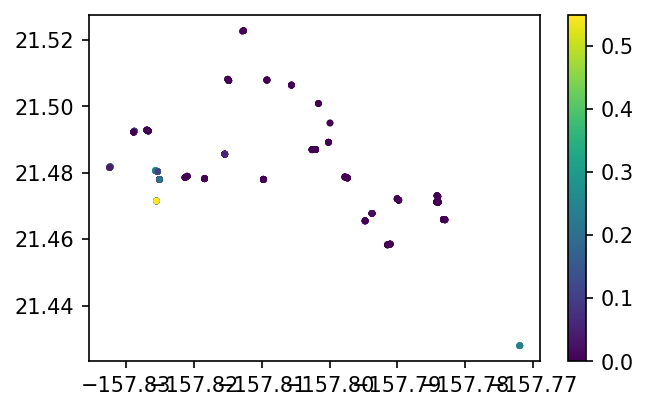

In [221]:
ind = (validation_data.Locale == 'Kaneohe Bay') & (endmember_coefficients.r2 > 0.7)
cvar = 'coral_brown'

plt.scatter(validation_data.loc[ind, 'X'], validation_data.loc[ind, 'Y'], c=endmember_coefficients.loc[ind, cvar], s=5)
plt.colorbar()


## Reduce Categories

In [259]:
new_categories = {
    'algae': ['algae_fleshy_brown', 'algae_fleshy_green', 'algae_fleshy_red', 'algae_turf', 'seagrass'],
    'CCA': ['algae_crustose_coralline'],
    'coral': ['coral_blue', 'coral_brown', 'octocoral'],
    'sand': ['sand', 'mud']
}

In [264]:
end_members = {}
for cat in new_categories:
    ind = df.index.isin(new_categories[cat])
    end_members[cat] = df.loc[ind].mean(axis=0)
end_member_array = np.array([spectrum.values for spectrum in end_members.values()])

In [273]:
endmember_coefficients_4 = pd.DataFrame(index=fits.index, columns=np.concat([list(new_categories.keys()), ['r2']]))

n = len(new_categories)

for i, row in tqdm(fits.iterrows(), total=fits.shape[0]):
    Rb = Rb_pca(*row.values[-3:])
    res = minimize(endmember_fit, np.zeros(n), args=(Rb), bounds=[(0,np.inf)]*n)
    Rb_pred = end_member_array.T.dot(res.x)
    
    endmember_coefficients_4.loc[i] = np.concat([res.x, [r2_score(Rb, Rb_pred)]]) 


  0%|          | 0/1938 [00:00<?, ?it/s]

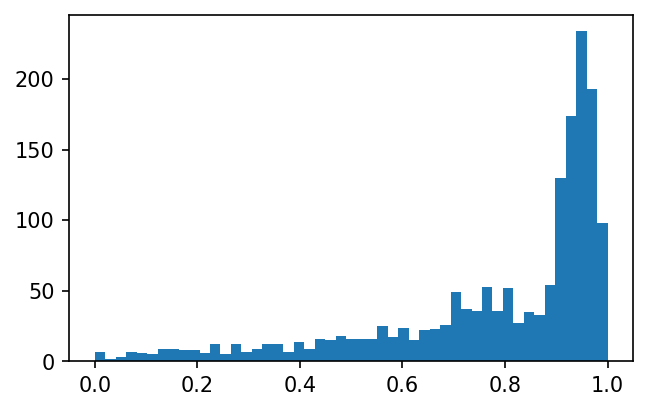

In [277]:
plt.hist(endmember_coefficients_4.r2, bins=np.linspace(0,1,50));

In [279]:
endmember_map_4 = {
    'CCA': ['algCCA'],
    'algae': ['algMacBrn', 'algMacGrn', 'algMacMix', 'algMacUnk', 'algCyano', 'algMacRed', 'algTurf', 'othSeagr'],    
    'coral': ['crlCoral', 'othOcto'],
    'sand': ['sedMud', 'sedSand', 'crlBleach', 'sedLimest', 'sedRubble'],
    # 'other': ['othClam', 'othInvert', 'othOther', 'othSponge', 'othUrchin']
}

validation_data_mapped_4 = pd.DataFrame(index=validation_data.index, columns=endmember_map)

for k, v in endmember_map_4.items():
    validation_data_mapped_4.loc[:, k] = validation_data.loc[:, v].sum(axis=1) 

validation_data_mapped_norm_4 = validation_data_mapped_4.divide(validation_data_mapped_4.sum(axis=1), axis=0)

endmember_coefficients_norm_4 = endmember_coefficients_4.iloc[:, :-1]
endmember_coefficients_norm_4 = endmember_coefficients_norm_4.divide(endmember_coefficients_norm_4.sum(axis=1), axis=0)

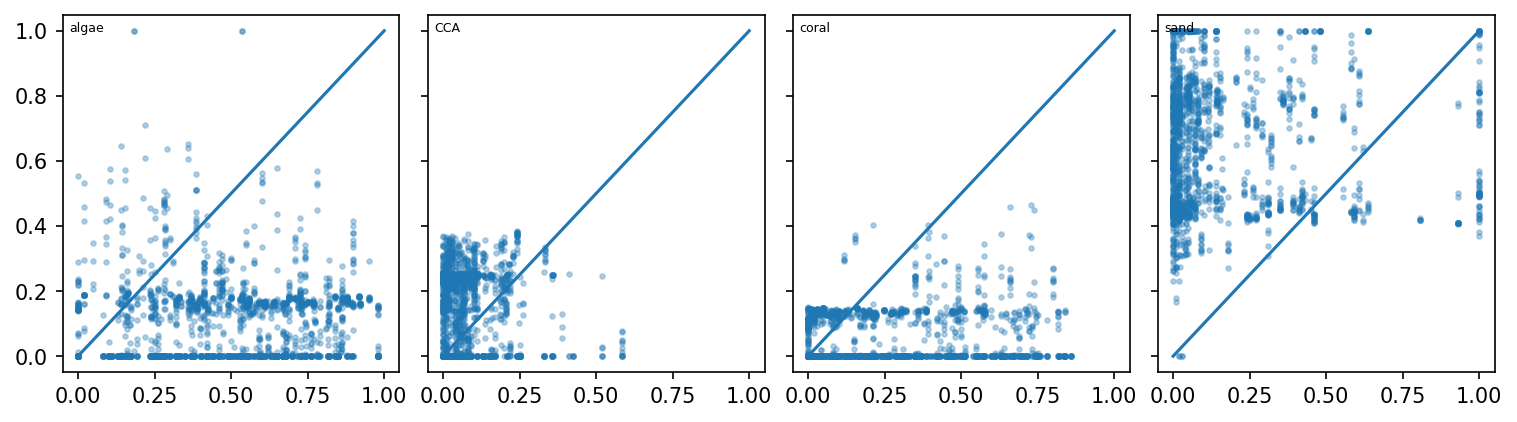

In [ ]:
fig, axs = plt.subplots(1,4,figsize=[10,2.7],sharex=True,sharey=True, constrained_layout=True)

for endmember, ax in zip(endmember_coefficients_norm_4.columns, axs.flat):
    ax.scatter(validation_data_mapped_4[endmember], endmember_coefficients_4[endmember], s=5, alpha=0.3)
    ax.text(0.02, 0.98, endmember, ha='left', va='top', transform=ax.transAxes, fontsize=6)
    
    ax.plot([0,1], [0,1])

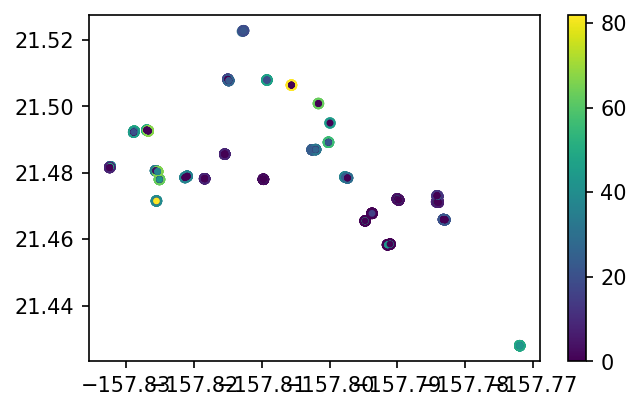

In [289]:
ind = (validation_data.Locale == 'Kaneohe Bay') & (endmember_coefficients.r2 > 0.7)
cvar = 'coral'

plt.scatter(validation_data.loc[ind, 'X'], validation_data.loc[ind, 'Y'], c=endmember_coefficients_4.loc[ind, cvar], s=5)
plt.scatter(validation_data.loc[ind, 'X'], validation_data.loc[ind, 'Y'], c=validation_data_mapped_4.loc[ind, cvar], s=20, zorder=-1)
plt.colorbar()
